In [ ]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


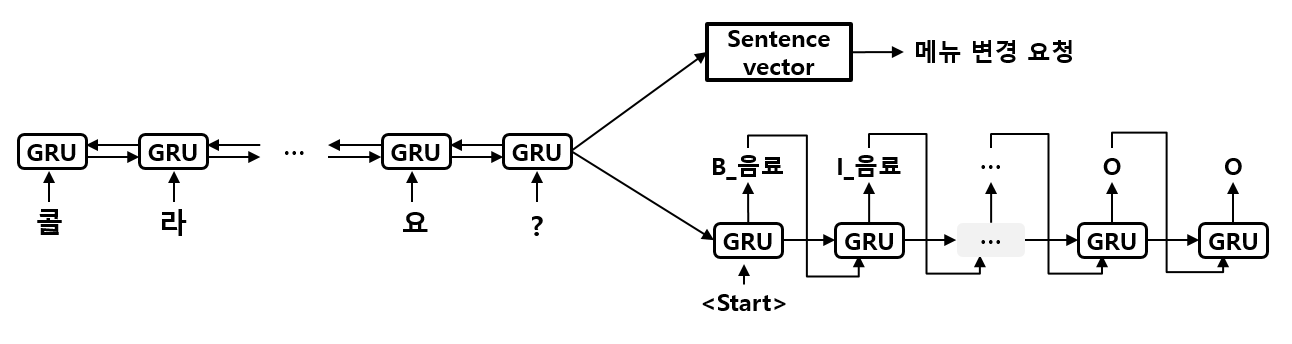

In [ ]:
from IPython.display import Image
import os
root_dir = "/gdrive/My Drive/task_oriented_chat"
Image(os.path.join(root_dir, "TaskOrientedChat_model.PNG"))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, TensorDataset)
import torch.optim as optim
from torch.autograd import Variable

import os
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import math

class Encoder(nn.Module):
    def __init__(self, embedding_size, hidden_size, dropout):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.gru = nn.GRU(input_size=embedding_size, hidden_size=hidden_size, num_layers=1,
                          dropout=dropout, batch_first=True, bidirectional=True)

    def forward(self, input, hidden=None):
        outputs, hidden = self.gru(input, hidden) # outputs : [batch, step, hidden_size*2] / hidden : [2, batch, hidden_size]

        # concat bidirectional hidden state
        hidden = torch.cat([hidden[0] ,
                  hidden[1]], -1).unsqueeze(0) # hidden : [1, batch, hidden_size*2]


        return outputs, hidden

class Decoder(nn.Module):
    def __init__(self, embedding_size, hidden_size, output_size,
                  dropout):
        super(Decoder, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embed = nn.Embedding(output_size, embedding_size)
        self.dropout = nn.Dropout(dropout, inplace=True)
        self.gru = nn.GRU(input_size=embedding_size, hidden_size=self.hidden_size, batch_first=True,
                          num_layers=1, dropout=dropout)

    def forward(self, input, last_hidden):
        # Get the embedding of the current input word (last output word)
        # batch
        embedded = self.embed(input) # (batch, embedding_size)
        embedded = embedded.unsqueeze(1) # (batch,1,embedding_size)
        embedded = self.dropout(embedded)
        # Calculate attention weights and apply to encoder outputs

        output, hidden = self.gru(embedded, last_hidden) # output : (batch, 1(step), hidden_size) hidden : (1(step x, num layer), batch, hidden_size)
        output = output.squeeze(1)  # (batch, hidden_size)
        return output, hidden



In [ ]:

class TaskOrientedChat(nn.Module):
    def __init__(self, flags):
        super(TaskOrientedChat, self).__init__()

        # 전체 음절 개수
        self.char_vocab_size = flags["char_vocab_size"]

        # 음절 임베딩 사이즈
        self.embedding_size = flags["embedding_size"]

        # GRU 히든 사이즈
        self.hidden_size = flags["hidden_size"]

        # 분류할 태그의 개수
        self.number_of_intent = flags["number_of_intents"] # 225
        self.number_of_slot_tag = flags["number_of_tags"] # 290

        # 디코딩 단계에서 필요한 문장 최대 길이
        self.max_sequence_length = flags["max_length"]
        

        # 입력 데이터에 있는 각 음절 index를 대응하는 임베딩 벡터로 치환해주기 위한 임베딩 객체
        # 기존에 사전학습 된 음절 임베딩을 사용할 수도 있고 랜덤으로 초기화 한 후,
        # 모델 학습 과정 중에 같이 학습 시키는 것도 가능
        # 예제 코드는 랜덤으로 초기화 한 후 같이 학습하도록 설정
        
        self.embedding = nn.Embedding(num_embeddings=self.char_vocab_size,
                                      embedding_dim=self.embedding_size,
                                      padding_idx=0)


        # Bi-GRU layer
        self.gru_encoder = Encoder(embedding_size=self.embedding_size, hidden_size=self.hidden_size, dropout=flags["dropout"])
        self.gru_decoder = Decoder(embedding_size=self.hidden_size*2, hidden_size=self.hidden_size*2, output_size=self.number_of_slot_tag, dropout=flags["dropout"])

        # fully_connected layer를 통하여 출력 크기를 number_of_tag와 num_intent에 맞춰줌
        # (batch_size, max_length, hidden_size) -> (batch_size, max_length, number_of_tags)
        self.hidden2num_intent = nn.Linear(in_features=self.hidden_size*2, out_features=self.number_of_intent)
        self.hidden2num_tag = nn.Linear(in_features=self.hidden_size*2, out_features=self.number_of_slot_tag)

    def forward(self, datas, train_flag=True):
        input_features, slot_labels, intent_labels = datas
        batch_size = input_features.shape[0]

        # 디코더 입력을 만들기 위한 [START] 심볼
        start_symbol = torch.ones(size=(batch_size, 1), dtype=torch.int64).cuda() # (batch, 1)
        decoder_input_features = torch.cat([start_symbol, slot_labels], -1)[:, :-1] # (batch, step)
        
        ##########
        char_inputs = self.embedding(input_features) # (batch_size, max_seq_length, embedding_size)

        _, encoder_hidden_state = self.gru_encoder(char_inputs) # (1, batch, hidden_size*2)

        # 디코더를 이용한 출력 값을 저장하기 위한 텐서
        outputs = Variable(torch.zeros(self.max_sequence_length, batch_size, self.number_of_slot_tag)).cuda()

        intent_logits = self.hidden2num_intent(encoder_hidden_state).squeeze(0) # (batch, num_intent)

        # 디코더 히든 초기값 설정
        decoder_hidden = encoder_hidden_state
        if train_flag:
            for t in range(self.max_sequence_length):
                decoder_input = Variable(decoder_input_features[:, t]) # (batch)

                decoder_output, decoder_hidden = self.gru_decoder(decoder_input, decoder_hidden) # decoder_output : (batch, hidden_size) / deocder_hidden : (1, batch, hidden_size)

                outputs[t] = self.hidden2num_tag(decoder_output)
            tag_logits = outputs.transpose(0, 1) # (batch, step, num_tag)

            return tag_logits.reshape(shape=(-1, self.number_of_slot_tag)).contiguous(), intent_logits # (batch*step, num_tag) / batch, num_intent)
        else:
            pre_decoder_output = start_symbol.squeeze(1) # (batch)
            for t in range(self.max_sequence_length):
                decoder_output, decoder_hidden = self.gru_decoder(pre_decoder_output, decoder_hidden)  # decoder_output : (batch, hidden_size) / deocder_hidden : (1, batch, hidden_size)
                pre_decoder_output = torch.argmax(self.hidden2num_tag(decoder_output), -1) # (batch, hidden) -> (batch, num_tag) -> (batch)
                outputs[t] = self.hidden2num_tag(decoder_output) # (batch, hidden) -> (batch, num_tag)


            tag_logits = torch.argmax(outputs.transpose(1, 0), -1)  # (step, batch, num_tag) -> (batch, step)
            intent_logits = torch.argmax(intent_logits, -1) # (batch, num_intent) -> (batch)

            return tag_logits, intent_logits # (batch, step) / (batch)


<h2>데이터 읽고 전처리 하기</h2>

<pre>
<b>Helper Class</b>
  전처리나 성능 평가 등의 기능을 제공하는 클래스

  함수 리스트

  def _load_vocab(self, vocab_file):
    # vocab 파일을 읽고 해당 딕셔너리를 생성하는 함수

  def _convert_data2feature(self, instance, symbol2idx, max_length=None):
    # 입력 데이터 instance를 고정 길이의 인덱스로 변환하는 함수
  
  def read_data(self, file_path):
    # 학습 or 평가 데이터를 읽어 고정 길이의 텐서로 표현하기 위한 함수
  
  def accuracy_score(self, answer_list, predict_list):
    # 의도 분류 예측 값을 평가하기 위한 함수
  
  
  def f1_score(self, answer_list, predict_list):
    # Slot tag 예측 값을 평가하기 위한 함수
  

In [ ]:

class Helper(object):
    def __init__(self, flags):
        self.flags = flags

        # 학습에 필요한 딕셔너리 생성
        self.word2idx, self.idx2word = self._load_vocab(flags["word_vocab_path"])
        self.tag2idx, self.idx2tag = self._load_vocab(flags["tag_vocab_path"])
        self.intent2idx, self.idx2intent = self._load_vocab(flags["intent_vocab_path"])

    # 파일을 읽고 딕셔너리 생성
    def _load_vocab(self, vocab_file):
        symbol2idx, idx2symbol = {}, {}

        word_vocab_file = open(vocab_file, "r", encoding="utf8").readlines()
        for line in word_vocab_file:
            word = line.strip()
            symbol2idx[word] = len(symbol2idx)
            idx2symbol[symbol2idx[word]] = word

        return symbol2idx, idx2symbol

    # 입력 데이터 instance를 고정 길이의 인덱스로 변환하는 함수
    def _convert_data2feature(self, instance, symbol2idx, max_length=None):
        '''

        :param instance: 인덱스로 치환하려는 데이터 (음절 sequence or tag sequence or 의도 라벨)
        :param symbol2idx: 입력 데이터 타입에 맞는 딕셔너리
        :param max_length: 의도 라벨의 경우는 하나의 문장에 대해 length가 존재하지 않음. 해당 파라미터를 통해 작업 수행
        :return:
        '''
        if max_length:
            # 사전 설정한 max_length의 길이를 갖는 numpy array 생성
            indexing_instance = np.zeros(shape=(max_length), dtype=np.int)

            # 음절 sequence 혹은 tag sequence를 index로 치환하고 위에서 생성한 numpy array에 저장
            for index in range(len(instance[:max_length])):
                if instance[index] in symbol2idx.keys():
                    indexing_instance[index] = symbol2idx[instance[index]]
                else:
                    indexing_instance[index] = symbol2idx["[UNK]"]
            return indexing_instance
        else:
            return symbol2idx[instance]

    # 학습 or 평가 데이터를 읽어 고정 길이의 텐서로 표현하기 위한 함수
    def read_data(self, file_path):
        with open(file_path, "r", encoding="utf8") as inFile:
            lines = inFile.readlines()

        char_sequences, tag_sequences, intents = [], [], []
        for line in tqdm(lines, desc="read_data"):
            # 입력 문장을 \t으로 분리
            pieces = line.strip().split("\t")

            # 데이터의 형태가 올바른지 체크
            assert len(pieces) == 3

            # 입력 문자열을 음절 단위로 분리
            char_sequence, tag_sequence, intent = pieces[0].split(), pieces[1].split(), pieces[2]

            # 음절 sequence의 길이와 라벨 sequence의 길이가 동일한지 체크
            assert len(char_sequence) == len(tag_sequence)

            # _convert_data2feature 함수를 통해 각 입력 값을 고정 길이의 array로 변환
            char_sequence = self._convert_data2feature(char_sequence, self.word2idx, self.flags["max_length"])
            indexing_tag = self._convert_data2feature(tag_sequence, self.tag2idx, self.flags["max_length"])
            indexing_intent = self._convert_data2feature(intent, self.intent2idx)

            char_sequences.append(char_sequence)
            tag_sequences.append(indexing_tag)
            intents.append(indexing_intent)
        char_sequences = torch.tensor(char_sequences, dtype=torch.long)
        tag_sequences = torch.tensor(tag_sequences, dtype=torch.long)
        intents = torch.tensor(intents, dtype=torch.long)

        return char_sequences, tag_sequences, intents

    def accuracy_score(self, answer_list, predict_list):
        correct = 0
        num = 0
        for idx, answer in enumerate(answer_list):
            if answer == 0:
                continue
            if answer == predict_list[idx]:
                correct+=1
            num+=1
        return correct/num

    def f1_score(self, answer_list, predict_list):
        recall_correct = 0
        recall_num = 0
        precision_correct =0
        precision_num = 0

        # 개체명 태그에 대해서만 성능을 측정
        none_symbol = self.tag2idx["O"]
        sp_symbol = self.tag2idx["<SP>"]

        for idx, answer in enumerate(answer_list):
            if answer == 0 or answer == none_symbol or answer == sp_symbol:
                continue
            if answer == predict_list[idx]:
                recall_correct+=1
            recall_num+=1

        for idx, predict in enumerate(predict_list):
            if predict == none_symbol or predict == 0 or predict == sp_symbol:
                continue
            if predict == answer_list[idx]:
                precision_correct+=1
            precision_num+=1

        try:
            recall = recall_correct/recall_num
            precision = precision_correct / precision_num
            print("recall = ", recall)
            print("precision ", precision)

            f1 = (precision*recall*2)/(precision+recall)
            return f1

        except:
            return 0

    def tensor2list(self, input_tensor):
        return input_tensor.cpu().detach().numpy().tolist()


In [ ]:

def train(flags):
    helper = Helper(flags)

    # 학습 데이터 읽기
    train_char_sequences, train_tag_sequences, train_intents = helper.read_data(flags["train_data_path"])

    # 평가 데이터 읽기
    test_char_sequences, test_tag_sequences, test_intents = helper.read_data(flags["test_data_path"])

    # 학습 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    train_features = TensorDataset(train_char_sequences, train_tag_sequences, train_intents)
    train_dataloader = DataLoader(train_features, shuffle=True, batch_size=flags["batch_size"])

    # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    test_features = TensorDataset(test_char_sequences, test_tag_sequences, test_intents)
    test_dataloader = DataLoader(test_features, shuffle=False, batch_size=1)

    #  모델 객체 생성
    model = TaskOrientedChat(flags).cuda()

    # 모델 학습을 위한 optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.003)


    # epoch 마다 성능을 비교하기 위한 변수
    max_f1 = 0
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    for epoch in range(flags["epoch"]):
        model.train()

        losses = []
        for step, batch in enumerate(tqdm(train_dataloader)):
            batch = tuple(t.cuda() for t in batch)

            # 음절 데이터, 각 데이터의 실제 길이, 라벨 데이터
            char_sequence, tag_sequence, intent = batch[0], batch[1], batch[2] 
            # (batch, step) / (batch, step) / (batch)


            # 모델 학습
            tag_output, intent_output = model((char_sequence, tag_sequence, intent), True) 
            # (batch*step, num_tags) / (batch, num_intent)

            tag_sequence = tag_sequence.reshape(shape=(-1,)) # (batch*step)

            tag_loss = criterion(tag_output, tag_sequence)
            intent_loss = criterion(intent_output, intent)

            total_loss = (tag_loss*0.8) + (intent_loss*0.2)

            optimizer.zero_grad()
            total_loss.backward()

            # 모델 내부 각 매개변수 가중치 갱신
            optimizer.step()

            # batch 단위 loss 값 저장
            losses.append(total_loss.data.item())

        model.eval()

        # 모델의 출력 결과와 실제 정답값을 담을 리스트
        total_tag_predicts, total_tag_answers, total_intent_predicts, total_intent_answers = [], [], [], []
        for step, batch in enumerate(tqdm(test_dataloader)):
            batch = tuple(t.cuda() for t in batch)
            # 음절 데이터, 각 데이터의 실제 길이, 라벨 데이터
            char_sequence, tag_sequence, intent = batch[0], batch[1], batch[2] 
            # (1, step) / (1, step) / (1)
            # 모델 평가
            tag_predicts, intent_predicts = model((char_sequence, tag_sequence, intent), False) 
            # (1(batch), step) / (1(batch))

            tag_answers, intent_answers = tag_sequence, intent

            # Tensor를 numpy array로 변경
            # batch 단위 출력 결과와 정답을 리스트에 저장
            total_tag_predicts += helper.tensor2list(tag_predicts)[0] # .squeeze(0)
            total_tag_answers += helper.tensor2list(tag_answers)[0] # .squeeze(0)

            total_intent_predicts += helper.tensor2list(intent_predicts)
            total_intent_answers += helper.tensor2list(intent_answers)

        # 의도 정확도 및 tag f1 점수 계산
        intent_accuracy = helper.accuracy_score(total_intent_answers, total_intent_predicts)
        tag_f1 = helper.f1_score(total_tag_answers, total_tag_predicts)

        if max_f1 < tag_f1:
            max_f1 = tag_f1
            torch.save(model.state_dict(), os.path.join(output_dir, "epoch.pt"))


        # epoch 별로 평균 loss 값과 정확도 출력
        print("Average loss : {},\tSlot Tag F1 score : {},\tIntent Accuracy : {}\n".format(np.mean(losses), tag_f1,
                                                                                   intent_accuracy))


<h2>TaskOrientedChat 모델 평가</h2>
<pre>
  def make_sentence(helper, char_sequence, tag_predicts, tag_answers, intent_predict, intent_answer):
  args
    helper : Helper 객체
    inputs : 음절 sequence
    tag_predicts : 예측 태그 sequence
    tag_answers : 정답 태그 sequence
    intent_predict : 예측 의도 class
    intent_answer : 예측 의도 class
    
  return
    정답 문장과 모델 출력 문장
</pre>
  

In [ ]:

# 모델 출력 라벨 sequence와 정답 라벨 sequence를 기반으로
# 모델 출력 문장과 정답 문장 출력
def make_sentence(helper, char_sequence, tag_predicts, tag_answers, intent_predict, intent_answer):
    # helper 객체를 통해 사전 load
    idx2char, idx2tag, idx2intent = helper.idx2word, helper.idx2tag, helper.idx2intent

    # 빈 문자열 생성
    input_sentence = []
    predict_tags = []
    answer_tags = []

    for index in range(len(char_sequence)):
        if char_sequence[index] == 0:
            break
        else:
            input_sentence.append(idx2char[char_sequence[index]])
            predict_tags.append(idx2tag[tag_predicts[index]])
            answer_tags.append(idx2tag[tag_answers[index]])
    predict_intent = idx2intent[intent_predict]
    answer_intent = idx2intent[intent_answer]

    origin_sentence = ' '.join(input_sentence)
    predict_result = ' '.join(predict_tags)
    answer_result =  ' '.join(answer_tags)
    print("###########################################")
    print(origin_sentence)
    print("정답 의도: {}\t 예측 의도: {}".format(answer_intent, predict_intent))

    return predict_result, answer_result


def test(flags):
    helper = Helper(flags)

    # 평가 데이터 읽기
    test_char_sequences, test_tag_sequences, test_intents = helper.read_data(flags["test_data_path"])

    # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    test_features = TensorDataset(test_char_sequences, test_tag_sequences, test_intents)
    test_dataloader = DataLoader(test_features, shuffle=True, batch_size=1)

    # TaskOrientedChat 모델 객체 생성
    model = TaskOrientedChat(flags).cuda()

    # 사전학습한 모델 파일로부터 가중치 불러옴
    model.load_state_dict(torch.load(os.path.join(flags["output_dir_path"], flags["trained_model_name"])))

    model.eval()

    # 모델의 출력 결과와 실제 정답값을 담을 리스트
    total_tag_predicts, total_intent_predicts, total_tag_answers, total_intent_answers = [], [], [], []
    for step, batch in enumerate(tqdm(test_dataloader, desc="test")):
        batch = tuple(t.cuda() for t in batch)

        # 음절 데이터, 각 데이터의 실제 길이, 라벨 데이터
        char_sequence, tag_sequence, intent = batch[0], batch[1], batch[2] # (1, step) / (1, step) / (1)

        # 모델 평가
        tag_predicts, intent_predict = model((char_sequence, tag_sequence, intent), False) # (1, step) / (1)

        # Tensor를 numpy array로 변경하고 입력 데이터의 실제 길이만큼 추출
        char_sequence = helper.tensor2list(char_sequence)[0] # (step)

        tag_predicts = helper.tensor2list(tag_predicts)[0] # (1, step) -> (step)
        tag_sequence = helper.tensor2list(tag_sequence)[0] # (1, step) -> (step)

        intent_predict = helper.tensor2list(intent_predict) # (1)
        intent_answer = helper.tensor2list(intent) # (1)

        # batch 단위 출력 결과와 정답을 리스트에 저장
        total_tag_predicts += tag_predicts
        total_tag_answers += tag_sequence

        total_intent_predicts += intent_predict
        total_intent_answers += intent_answer

        if (step < 10):
            # 정답과 모델 출력 비교
            predict_tag_sequence, correct_tag_sequence = make_sentence(helper, char_sequence, tag_predicts, tag_sequence, intent_predict[0], intent_answer[0])
            print("\n정답: " + correct_tag_sequence)
            print("모델 출력: " + predict_tag_sequence)
            print("###########################################\n\n")

    # 정확도 출력
    print("TAG F1 score : {}\tIntent Accuracy : {}".format(helper.f1_score(total_tag_answers, total_tag_predicts),
                                                        helper.accuracy_score(total_intent_answers, total_intent_predicts)))



In [ ]:

import os
if(__name__=="__main__"):
    output_dir = os.path.join(root_dir, "output")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    flags = {"mode": "test",
              "trained_model_name":"epoch.pt",
              "train_data_path":os.path.join(root_dir, "r_train.txt"),
              "test_data_path": os.path.join(root_dir, "r_test.txt"),
              "output_dir_path":output_dir,
              "word_vocab_path": os.path.join(root_dir, "vocab.txt"),
              "tag_vocab_path": os.path.join(root_dir, "slot_label.txt"),
             "intent_vocab_path": os.path.join(root_dir, "intent_label.txt"),
              "char_vocab_size": 783,
              "embedding_size": 100,
              "hidden_size": 200,
              "max_length": 30,
              "number_of_tags": 290,
             "number_of_intents": 225,
              "epoch":50,
              "batch_size":128,
              "dropout":0.2
              }

    if(flags["mode"] == "train"):
        train(flags)
    else:
        test(flags)

read_data: 100%|██████████| 384/384 [00:00<00:00, 34597.40it/s]
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
test:   2%|▏         | 6/384 [00:00<01:07,  5.62it/s]

###########################################
안 녕 하 세 요 <SP> 청 국 장 <SP> 하 나 <SP> 주 세 요
정답 의도: 식사주문	 예측 의도: 식사주문

정답: O O O O O <SP> B_메뉴 I_메뉴 I_메뉴 <SP> B_수량 I_수량 <SP> O O O
모델 출력: O O O O O <SP> B_메뉴 I_메뉴 <SP> B_수량 I_수량 <SP> O O O O
###########################################


###########################################
짬 뽕 으 로 <SP> 두 <SP> 개 <SP> 주 세 요
정답 의도: 식사주문	 예측 의도: 식사주문

정답: B_메뉴 I_메뉴 O O <SP> B_수량 <SP> I_수량 <SP> O O O
모델 출력: B_메뉴 I_메뉴 I_메뉴 O <SP> O <SP> B_수량 I_수량 <SP> O O
###########################################


###########################################
종 류 는 <SP> 어 떤 <SP> 게 <SP> 있 나 요 <SP> 치 킨 이 ?
정답 의도: 메뉴문의	 예측 의도: 메뉴문의

정답: O O O <SP> O O <SP> O <SP> O O O <SP> B_메뉴 I_메뉴 O O
모델 출력: O O O <SP> O O <SP> B_메뉴 I_메뉴 <SP> O O O <SP> O O <SP>
###########################################


###########################################
메 뉴 판 <SP> 따 로 <SP> 있 어 요 ?
정답 의도: 메뉴판요청	 예측 의도: 메뉴판요청

정답: B_비품 I_비품 I_비품 <SP> O O <SP> O O O O
모델 출력: B_비품 I_비품 I_비품 <SP> O O <SP> O O O O
#####

test: 100%|██████████| 384/384 [00:08<00:00, 43.71it/s]

recall =  0.5095471903982542
precision  0.5979513444302177
TAG F1 score : 0.5502209131075111	Intent Accuracy : 0.6041666666666666


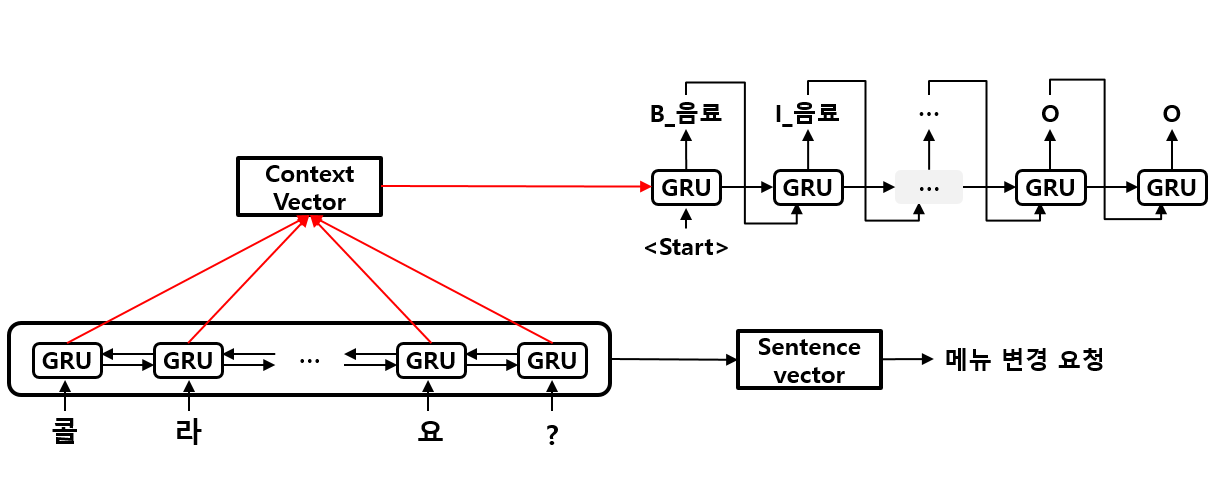

In [ ]:

Image(os.path.join(root_dir, "TaskOrientedChat_homework.PNG"))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, TensorDataset)
import torch.optim as optim
from torch.autograd import Variable

import os
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import math

class Encoder(nn.Module):
    def __init__(self, embedding_size, hidden_size, dropout):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.gru = nn.GRU(input_size=embedding_size, hidden_size=hidden_size, num_layers=1,
                          dropout=dropout, batch_first=True, bidirectional=True)

    def forward(self, input, hidden=None):
        outputs, hidden = self.gru(input, hidden) # outputs : [batch, step, hidden_size*2] / hidden : [2, batch, hidden_size]

        # concat bidirectional hidden state
        hidden = torch.cat([hidden[0] ,
                  hidden[1]], -1).unsqueeze(0) # hidden : [1, batch, hidden_size*2]


        return outputs, hidden

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdv = 1. / math.sqrt(self.v.size(0))
        self.v.data.uniform_(-stdv, stdv)

    def forward(self, hidden, encoder_outputs):
        timestep = encoder_outputs.size(0) # step
        h = hidden.repeat(timestep, 1, 1).transpose(0, 1) # (step, batch, hidden) -> (batch, step, hidden)
        encoder_outputs = encoder_outputs.transpose(0, 1)  # (batch, step, hidden)
        attn_energies = self.score(h, encoder_outputs) # (batch, step)
        return F.softmax(attn_energies, dim=1).unsqueeze(1) # (batch, 1, step)

    def score(self, hidden, encoder_outputs):
        energy = F.relu(self.attn(torch.cat([hidden, encoder_outputs], 2))) # (batch, step, hidden*2)->(batch, step, hidden)
        energy = energy.transpose(1, 2)  # [batch, hidden_size, step]
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)  # [batch, 1, hidden_size]
        energy = torch.bmm(v, energy)  # [batch, 1, step]
        return energy.squeeze(1)  # [batch, step]


class AttentionDecoder(nn.Module):
    def __init__(self, embedding_size, hidden_size, output_size,
                  dropout):
        super(AttentionDecoder, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.attention = Attention(hidden_size)

        self.embed = nn.Embedding(output_size, embedding_size)
        self.dropout = nn.Dropout(dropout, inplace=True)
        self.gru = nn.GRU(input_size=hidden_size + embedding_size, hidden_size=self.hidden_size, batch_first=True,
                          num_layers=1, dropout=dropout)

    def forward(self, input, last_hidden, encoder_outputs):
        # Get the embedding of the current input word (last output word)
        embedded = self.embed(input) # (batch, embedding_size)
        embedded = embedded.unsqueeze(1) # (batch,1,embedding_size)
        embedded = self.dropout(embedded)

        encoder_outputs = encoder_outputs.transpose(0, 1) # (step, batch, hidden_size)
        
        # Calculate attention weights and apply to encoder outputs
        attn_weights = self.attention(last_hidden[-1], encoder_outputs) # (batch, 1, step)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) #(batch, 1, hidden)
        rnn_input = torch.cat([embedded, context], 2) # (batch, 1, hidden+embedding)
        output, hidden = self.gru(rnn_input, last_hidden) # output : (batch, 1, hidden_size) hidden : (1, batch, embedding_size)
        output = output.squeeze(1)  # (batch, hidden_size)
        return output, hidden